# ProblemSchemaComme3D

In [1]:
import sys
import os

lib_path = os.path.realpath(os.path.join(os.getcwd(), ".."))
if lib_path not in sys.path:
    sys.path = [lib_path] + sys.path
save_fig = True
savefig_path = os.path.join(lib_path, "figures/Energie3D/")

In [2]:
from src.main_discontinu import *
from src.plot_fields import *

%matplotlib widget
# rc("figure", figsize=(10, 5))
rc("figure", dpi=100)

# Paramètres de la simulation

Ici on va réaliser une simulation sans diffusion pour différentes écritures de notre équation thermique.

La résolution se fait à chaque fois en QUICK avec Euler explicite en temps.

La référence utilisée est une simulation TOF sur maillage fin.

In [3]:
n_lim = 10**9
t_fin_lim = 0.2

In [4]:
from copy import copy

Vtot = 0.02 * 0.005**2

phy_prop = PhysicalProperties(
    Delta=0.02,
    v=0.2,
    dS=0.005**2,
    lda1=5.5 * 10**-2,
    lda2=15.5,
    rho_cp1=70278.0,
    rho_cp2=702780.0,
    diff=1.0,
    alpha=0.06,
    a_i=357.0,
)

phy_prop_sans_conv = copy(phy_prop)
phy_prop_sans_conv.v = 0.0

num_prop = NumericalProperties(
    dx=3.9 * 10**-5, schema="quick", time_scheme="euler", phy_prop=phy_prop, cfl=1.0
)
num_prop_ref = NumericalProperties(
    dx=1.0 * 10**-5, schema="weno", time_scheme="rk3", phy_prop=phy_prop, cfl=1.0
)
markers = BulleTemperature(phy_prop=phy_prop, x=num_prop.x, n_bulle=1)
# markers.shift(0.007)
# markers = Bulles(phy_prop=phy_prop)

In [5]:
init_params_ref = {
    "markers": markers,
    "phy_prop": phy_prop_sans_conv,
    "num_prop": num_prop_ref,
}
init_params = {"markers": markers, "phy_prop": phy_prop, "num_prop": num_prop}

# Test de l'opérateur ProblemDiscontinuEcomme3D

La simulation est réalisée avec la forme actuelle du code 3D

Dans ce cas là, il n'y a pas de modification des flux calculés en QUICK qui ne sont pas sur des faces coupées. Ainsi les flux qui sont à proximité de l'interface sont calculés avec une interpolation qui prend en compte la valeur de la cellule diphasique.

## Simulation comparée

In [6]:
prob_ref = Problem(
    get_T_creneau,
    **init_params_ref,
)
prob_E = ProblemDiscontinuE(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
)
prob_3d = ProblemDiscontinuEcomme3D(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
)
prob_T = Problem(
    get_T_creneau,
    **init_params,
)


TOF
===
dt fourier
4.538601983461999e-07
Db / dx = 119

ESP
===
dt fourier
6.918433404737903e-06
Db / dx = 30
Ti

ESP 3D
dt fourier
6.918433404737903e-06
Db / dx = 30
Ti

TOF
===
dt fourier
6.918433404737903e-06
Db / dx = 30


Liste des simus similaires : 
['References/prob_ref_t_0.150000.pkl', 'References/prob_ref_t_0.200000.pkl']
Attention, les markers initiaux ne sont pas enregistrés dans la référence
Loading ======> References/prob_ref_t_0.200000.pkl
remaining time to compute : 0.000000


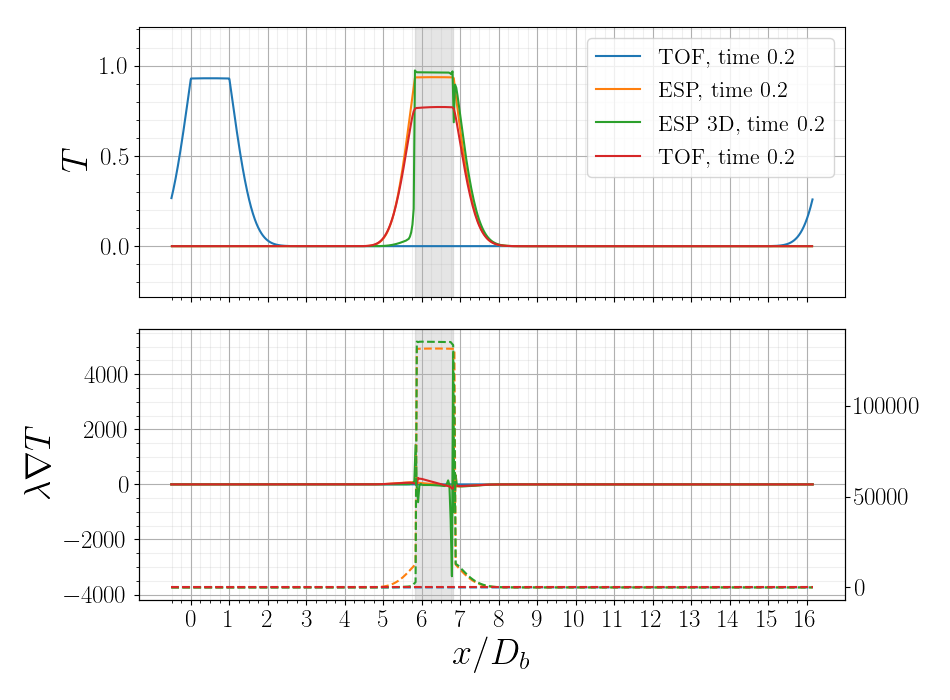

In [7]:
t_fin = 1.0

plot_tot = Plotter("decale", flux_conv=True, lda_gradT=True)

time_args = {"t_fin": min(t_fin, t_fin_lim), "n": n_lim, "number_of_plots": 1}

t_ref, e_ref = prob_ref.load_or_compute(
    pb_name="prob_ref", **time_args, plotter=[plot_tot]
)
t_e, e_e = prob_E.timestep(**time_args, plotter=[plot_tot])
t_3d, e_3d = prob_3d.timestep(**time_args, plotter=[plot_tot])
t_T, e_T = prob_T.timestep(**time_args, plotter=[plot_tot])

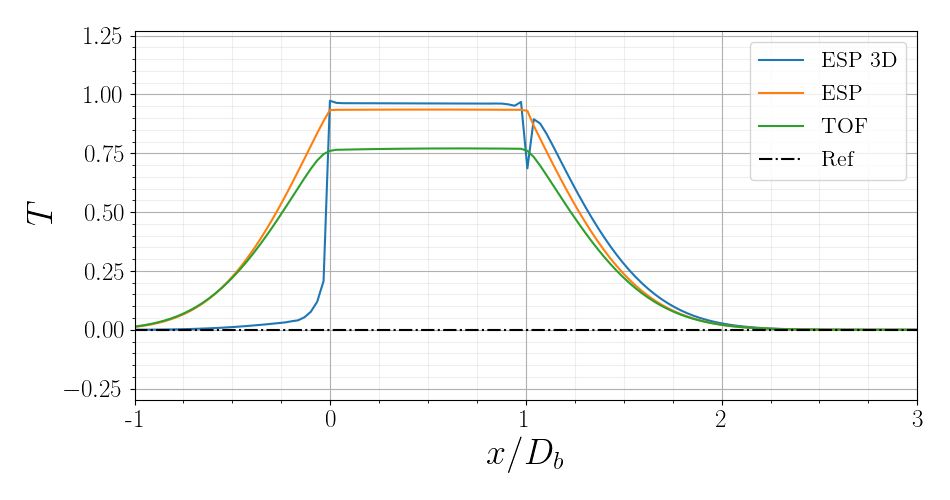

In [8]:
plotter = Plotter(
    "decale",
    flux_conv=False,
    lda_gradT=False,
    ispretty=True,
    zoom=(-1.0, 3.0),
    time=False,
)
plotter.plot(prob_3d, plot_Ti=False)
plotter.plot(prob_E, plot_Ti=False)
plotter.plot(prob_T)
plotter.plot(prob_ref, c="k", ls="-.", label="Ref")
# plotter.ax.set_xlim(0., 0.003)
if save_fig:
    plotter.fig.savefig(savefig_path + "ESP3D.pdf")


Ref
===
dE*/dt* = -3.28604e-10

TOF
===
dE*/dt* = -3.68698e-06

ESP 3D
dE*/dt* = 0


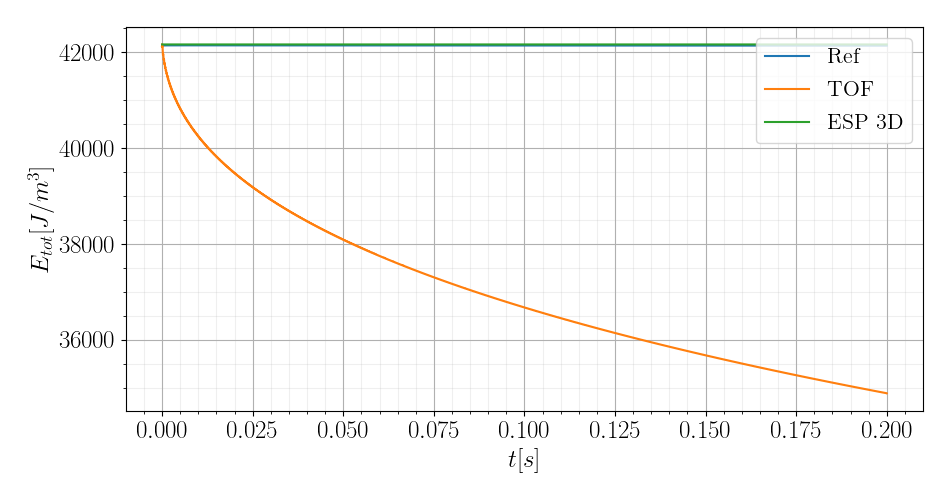

In [9]:
plot_en = EnergiePlot()
plot_en.plot_pb(prob_ref, fac=Vtot, label="Ref")
plot_en.plot_pb(prob_T, fac=Vtot)
plot_en.plot_pb(prob_3d, fac=Vtot)
# plot_en.add_E0()

# Comme 3D avec Ghost cell

Ici on corrige les flux aux faces à proximité de l'interface en utilisant une température ghost.

La résolution se fait à chaque fois en Quick avec Euler explicite en temps.

## Flux convectif corrigé Quick ou upwind

### Simulations

Les problèmes suivants sont calculés :

- **ProblemDiscontinuComme3D_ghost** :  
    On utilise les valeurs ghosts de la maille diphasique pour corriger les flux convectifs à proximité de
  l'interface (dans le stencil du quick).
    Au corrige donc les flux en $i-1/2$, $i+1/2$ et $i+3/2$.
    Deux choix ont été implémentés :
    - On utilise quick pour $i-1/2$ et $i+3/2$ avec la valeur ghost gauche et droite resp., et une interpolation upwind avec $T_I$ et $\nabla T_{I_{droit}}$ pour $i+1/2$
    - On utilise upwind pour tous

In [10]:
prob_gq = ProblemDiscontinuEcomme3D_ghost(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
    conv_interf="quick_ghost",
)
prob_gu = ProblemDiscontinuEcomme3D_ghost(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
    conv_interf="quick_upwind_ghost",
)


ESP 3D ghost, CN
dt fourier
6.918433404737903e-06
Db / dx = 30
Ti

ESP 3D ghost, CN
dt fourier
6.918433404737903e-06
Db / dx = 30
Ti


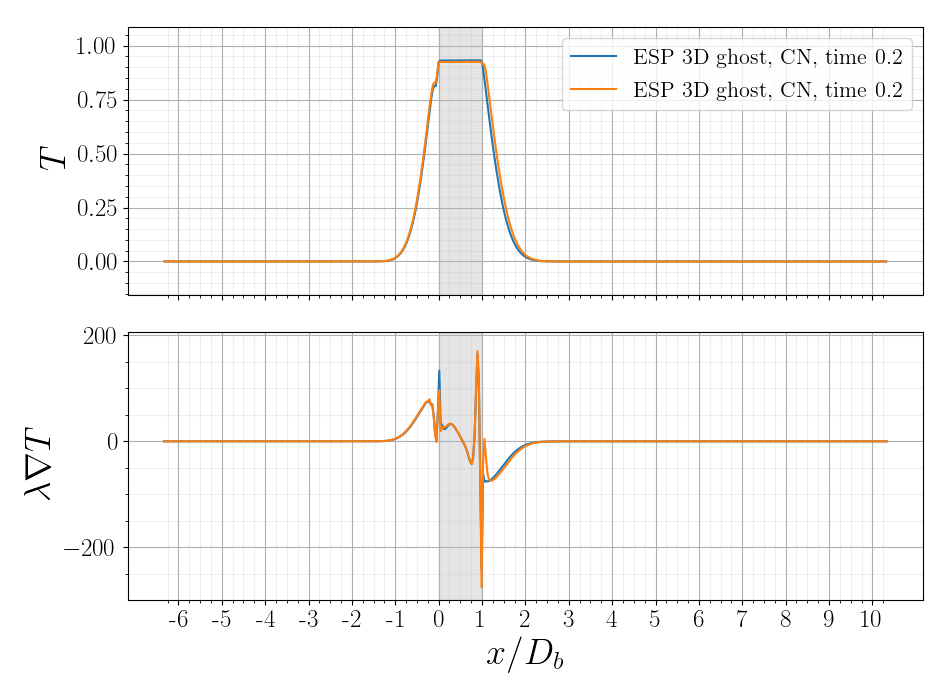

In [11]:
t_fin = 1.0

plot_tot = Plotter("decale", flux_conv=False, lda_gradT=True)

time_args = {"t_fin": min(t_fin, t_fin_lim), "n": n_lim, "number_of_plots": 1}

# prob_ref, t_ref, e_ref = load_or_compute(prob_ref, **time_args, plotter=[plot_tot])

t_gq, e_gq = prob_gq.timestep(
    **time_args,
    plotter=[plot_tot],
    plot_Ti=True,
)

t_gu, e_gu = prob_gu.timestep(
    **time_args,
    plotter=[plot_tot],
    plot_Ti=True,
)

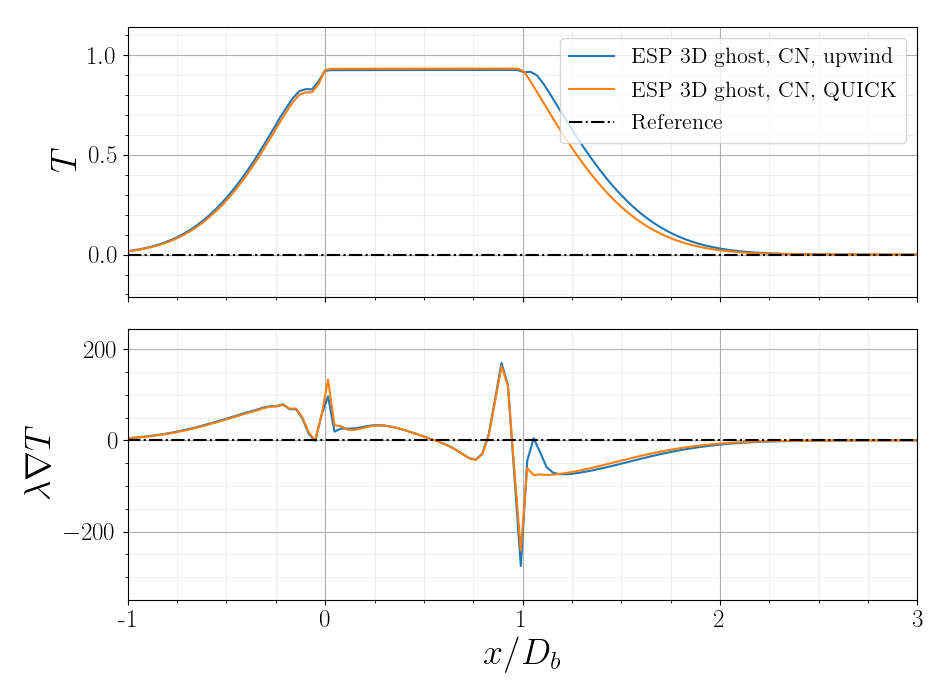

In [12]:
plotter = Plotter(
    "decale",
    flux_conv=False,
    lda_gradT=True,
    ispretty=True,
    zoom=(-1.0, 3.0),
    time=False,
)
plotter.plot(prob_gu, plot_Ti=True, label="ESP 3D ghost, CN, upwind")
plotter.plot(prob_gq, plot_Ti=True, label="ESP 3D ghost, CN, QUICK")
plotter.plot(prob_ref, c="k", ls="-.", label="Reference")
# plotter.plot(prob_T)
# plotter.ax.set_xlim(0., 0.003)
if save_fig:
    plotter.fig.savefig(savefig_path + "ESP3Dghost_scheme.pdf")

### Observations

On observe la choses suivante :
- La différence entre ESP3D quick et ESP3D upwind est importante en amont de la bulle, et faible en aval, on implémentera donc plutôt la version quick.

# Recherche des différences avec la référence

Dans cette partie on analyse les différences entre la solution retenue et implémentée en 3D et la solution qui avait été proposée dans l'article.

On va améliorer la version 3D et dégrader la solution ESP pour voir ou sont les points importants.

Toutes ces solutions seront comparées à la solution qui sera implémentée et à la référence.

## Analyse de la correction du flux diffusif sur la solution

### Simulations

Les problèmes suivants sont calculés :

- **ProblemDiscontinuEcomme3Davecq_ghost** :  
    C'est la meme chose mais on corrige aussi le flux diffusif avec les valeurs de température ghost.
    
- **ProblemDiscontinuEsansq** :  
    C'est la meme chose que ProblemDiscontinuE mais sans la correction de la diffusion (on utilise les valeurs monofluides).
    

In [13]:
prob_gqd = ProblemDiscontinuEcomme3Davecq_ghost(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
    conv_interf="quick_ghost",
)
prob_Esd = ProblemDiscontinuEsansq(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
)


ESP 3D ghost, corr. diff.
dt fourier
6.918433404737903e-06
Db / dx = 30
Ti

ESP sans corr. diff.
dt fourier
6.918433404737903e-06
Db / dx = 30
Ti


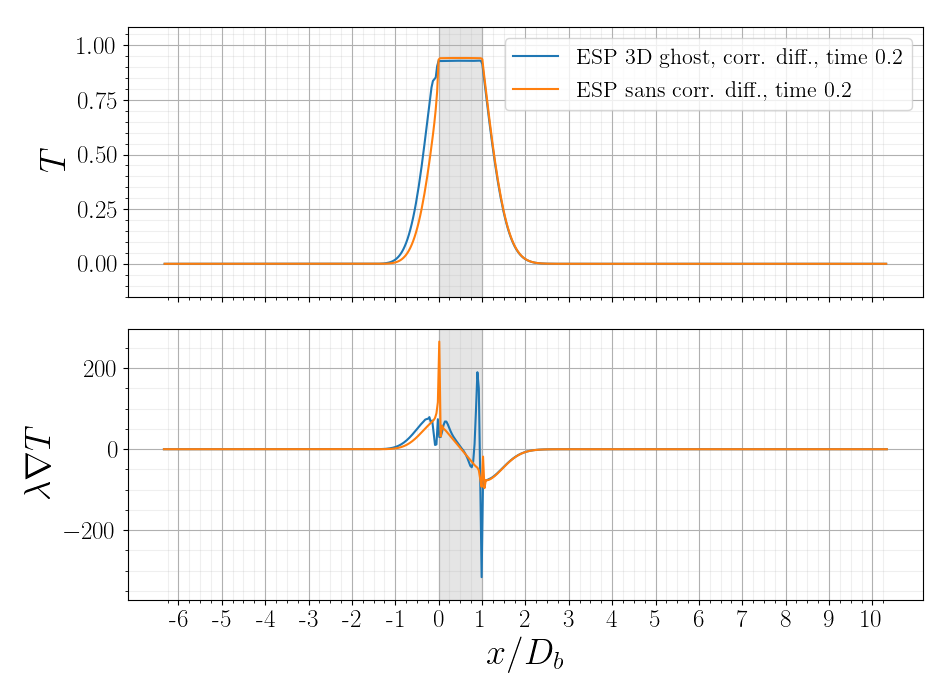

In [14]:
t_fin = 1.0

plot_tot = Plotter("decale", flux_conv=False, lda_gradT=True)

time_args = {"t_fin": min(t_fin, t_fin_lim), "n": n_lim, "number_of_plots": 1}

# prob_ref, t_ref, e_ref = load_or_compute(prob_ref, **time_args, plotter=[plot_tot])

tacq, eacq = prob_gqd.timestep(
    **time_args,
    plotter=[plot_tot],
    plot_Ti=True,
)

# t1, e1 = prob_E.timestep(
#     **time_args,
#     plotter=[plot_tot],
# )

t2, e2 = prob_Esd.timestep(
    **time_args,
    plotter=[plot_tot],
)

Essayer de comprendre pourquoi la version sans diffusion ESP est si loin de la référence.

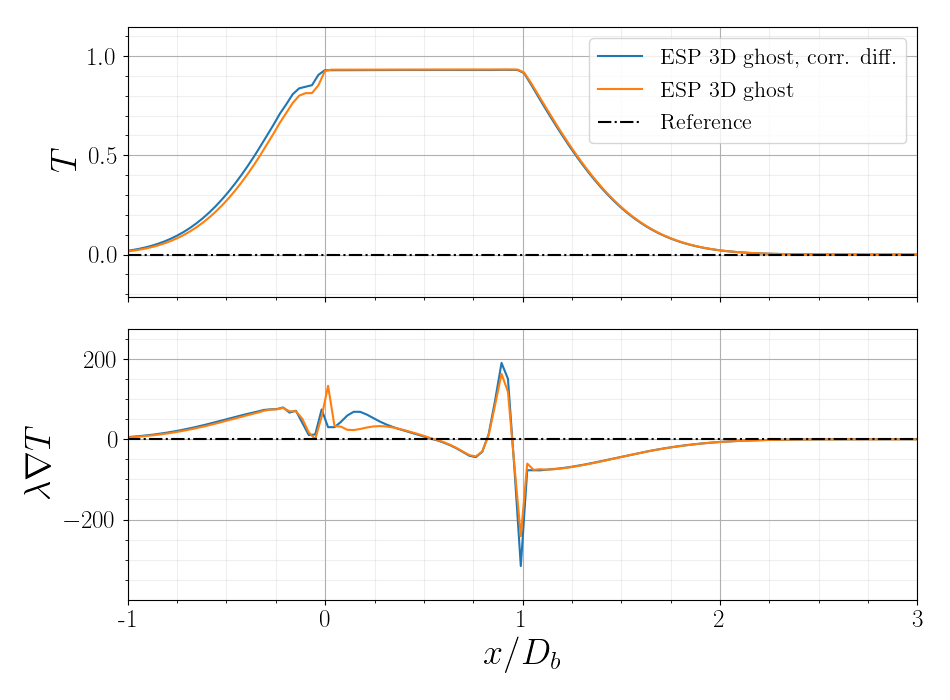

In [15]:
plotter = Plotter(
    "decale",
    flux_conv=False,
    lda_gradT=True,
    ispretty=True,
    zoom=(-1.0, 3.0),
    time=False,
)
plotter.plot(prob_gqd, plot_Ti=True)
plotter.plot(prob_gq, plot_Ti=True, label="ESP 3D ghost")
plotter.plot(prob_ref, c="k", ls="-.", label="Reference")
# plotter.plot(prob_T, plot_Ti=False)
# plotter.ax.set_xlim(0., 0.003)
if save_fig:
    plotter.fig.savefig(savefig_path + "ESP3Dghost_corr_diff.pdf")

Vérifier qu'il n'y a pas un glissement de 1 dans le code

'#ff7f0e'

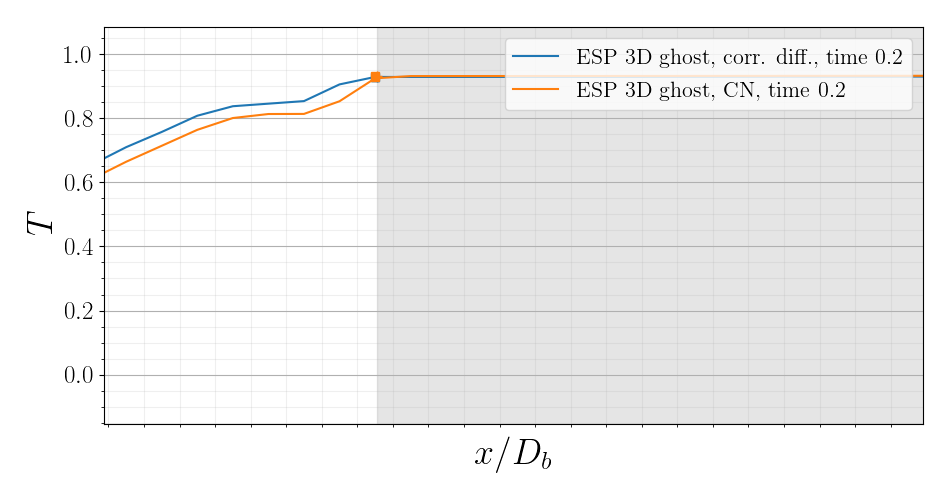

In [16]:
plotter = Plotter(
    "classic", flux_conv=False, lda_gradT=False, ispretty=False, zoom=(-0.25, 0.5)
)
plotter.plot(prob_gqd, plot_Ti=True)
plotter.plot(prob_gq, plot_Ti=True)
# plotter.ax.set_xlim(0.002, 0.005)

C'est bon pas de glissement !

TODO: faire la meme chose mais avec ESP CN sans corr de diff.

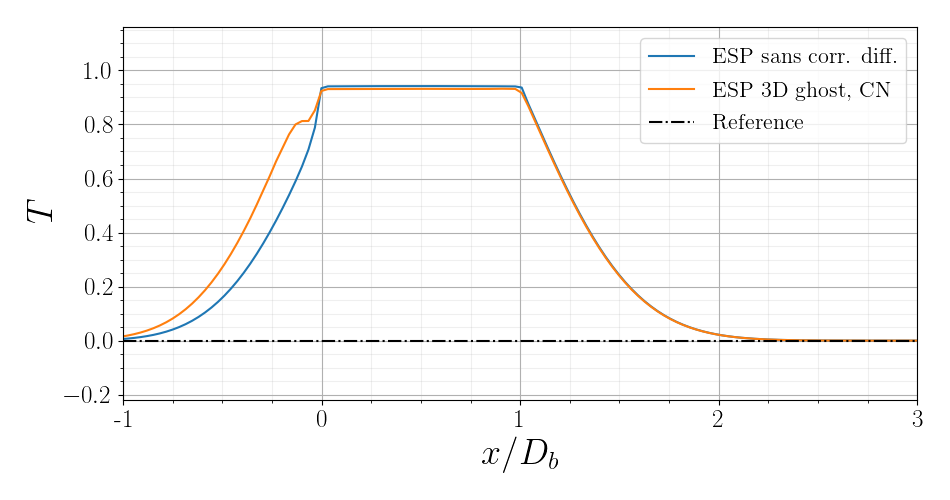

In [17]:
plotter = Plotter(
    "decale",
    flux_conv=False,
    lda_gradT=False,
    ispretty=True,
    zoom=(-1.0, 3.0),
    time=False,
)
plotter.plot(prob_Esd, plot_Ti=True)
plotter.plot(prob_gq, plot_Ti=True)
plotter.plot(prob_ref, c="k", ls="-.", label="Reference")
# plotter.plot(prob_T)
# plotter.ax.set_xlim(0., 0.003)
if save_fig:
    plotter.fig.savefig(savefig_path + "ESP_sans_corr_diff.pdf")

Guillaume et Adrien n'aiment pas trop ce qui se passe en amont de la bulle. C'est probablement du au schéma Quick qui est oscillant.

### Observations

On observe les choses suivantes :
- ESP sans corriger le flux diffusif ne donne pas la meme erreur que celle qu'on observe avec ESP3D, je suppose que cette différence vient plutôt de la non intégration exacte en temps de $\rho C_p$ qui est intégré en Crank-Nicolson ($n+ \frac{1}{2}$).
- La version ESP3D avec correction des flux avec différence centrée en utilisant les valeurs ghost droites et gauches ne donne pas de meilleurs résultats que sans cette correction. Pas d'implémentation en 3D donc.


TOF
===
dE*/dt* = -3.28604e-10

ESP 3D ghost, CN
dE*/dt* = 1.1201e-19

ESP 3D ghost, CN
dE*/dt* = 7.46732e-20

ESP
===
dE*/dt* = -4.48039e-20


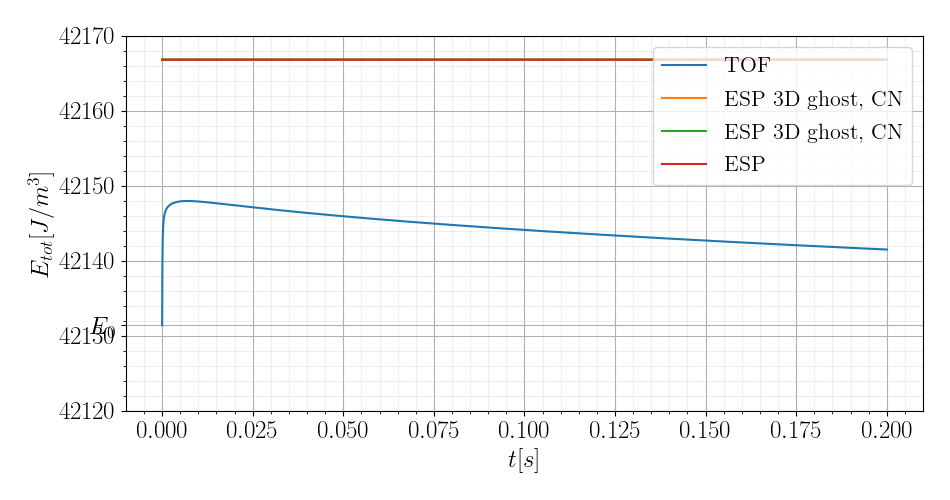

In [18]:
en_plot = EnergiePlot()
en_plot.plot_pb(prob_ref, fac=Vtot)
en_plot.plot_pb(prob_gq, fac=Vtot)
en_plot.plot_pb(prob_gu, fac=Vtot)
en_plot.plot_pb(prob_E, fac=Vtot)
en_plot.add_E0()

## Analyse de l'effet de l'intégration en temps des surfaces mouillées

Ici on cherche à comprendre la différence entre la référence (TOF sans convection) et le bon résultat (perfectible probablement) obtenu avec la correction des flux ayant recours aux cellules ghosts.

### Simulations

Les méthodes fonctionnent de la manière suivante :

- **ProblemDiscontinuE_CN** :  
    La résolution de référence sans l'intégration précise en temps des surfaces mouillées.
    
- **ProblemDiscontinuComme3D_ghost_exactSf** :  
    C'est la meme chose mais on calcule les surfaces mouillées en les intégrant exactement (grace au 1D).
    

In [19]:
prob_gqS = ProblemDiscontinuEcomme3D_ghost_exactSf(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
    conv_interf="quick_ghost",
)

prob_Ecn = ProblemDiscontinuE_CN(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
)


ESP 3D ghost, exact Sf
dt fourier
6.918433404737903e-06
Db / dx = 30
Ti

ESP CN
dt fourier
6.918433404737903e-06
Db / dx = 30
Ti


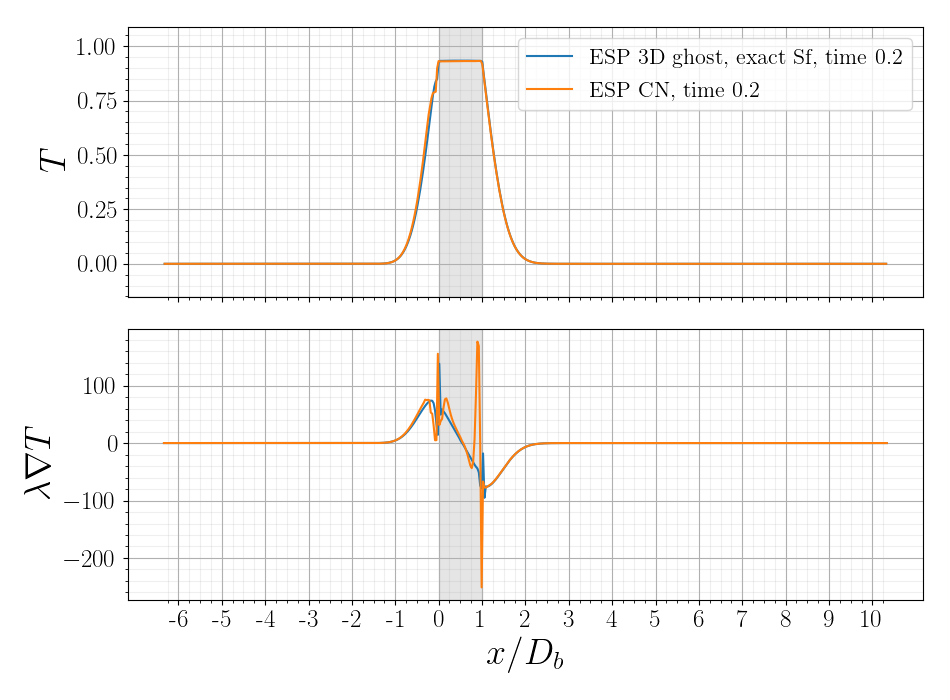

In [20]:
t_fin = 1.0

plot_tot = Plotter("decale", flux_conv=False, lda_gradT=True)

time_args = {"t_fin": min(t_fin, t_fin_lim), "n": n_lim, "number_of_plots": 1}

tguS, eguS = prob_gqS.timestep(
    **time_args,
    plotter=[plot_tot],
    plot_Ti=True,
)
te1, ee1 = prob_Ecn.timestep(
    **time_args,
    plotter=[plot_tot],
)

'k'

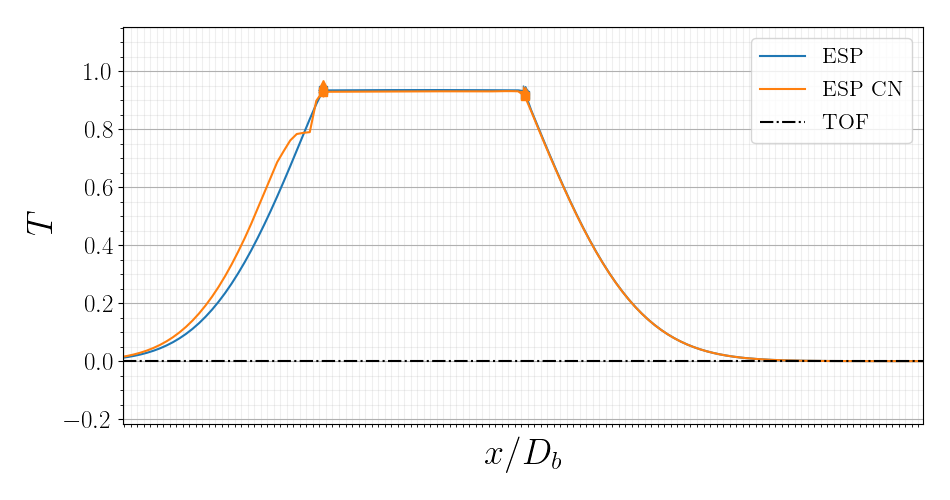

In [21]:
plotter = Plotter(
    "decale",
    flux_conv=False,
    lda_gradT=False,
    ispretty=False,
    zoom=(-1.0, 3.0),
    time=False,
)
plotter.plot(prob_E, plot_Ti=True)
plotter.plot(prob_Ecn, plot_Ti=True)
plotter.plot(prob_ref, c="k", ls="-.")

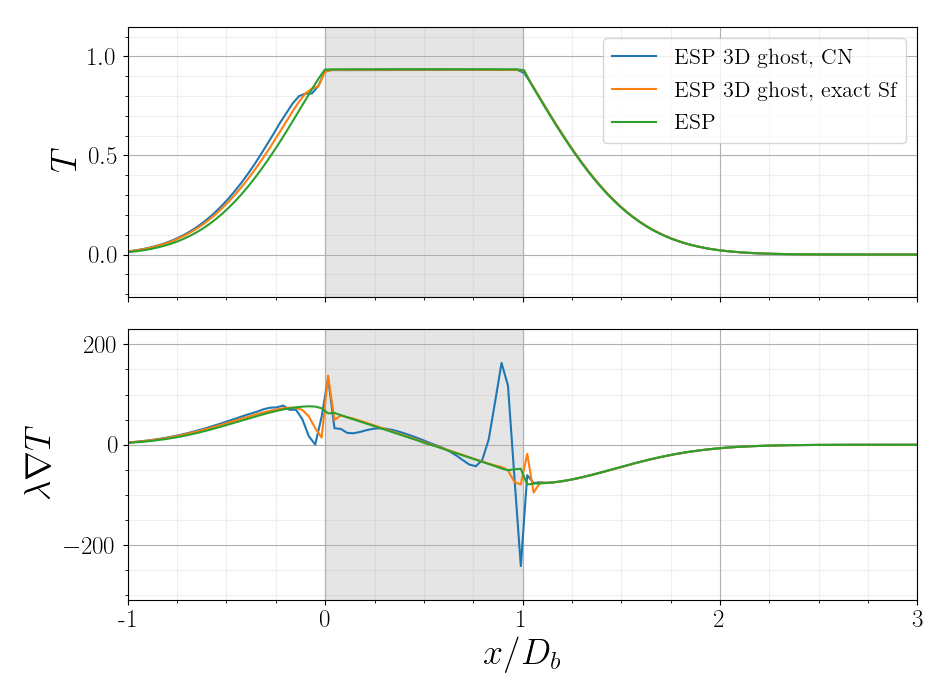

In [22]:
plotter = Plotter(
    "decale",
    flux_conv=False,
    lda_gradT=True,
    ispretty=True,
    zoom=(-1.0, 3.0),
    time=False,
)
plotter.plot(prob_gq, plot_Ti=True)
plotter.plot(prob_gqS, plot_Ti=True)
plotter.plot(prob_E)
# plotter.plot(prob_ref, c="k", ls="-.", label="Ref")
# plotter.ax3.set_ylabel(r'$\rho C_p T$', size='x-large')
# plotter.ax.set_xlim(-0.0001, 0.0201)
# plotter.ax.set_ylim(0.,1.)
plotter.fig.tight_layout()
if save_fig:
    plotter.fig.savefig(savefig_path + "ESP_ESP3Dghost_exactSf.pdf")

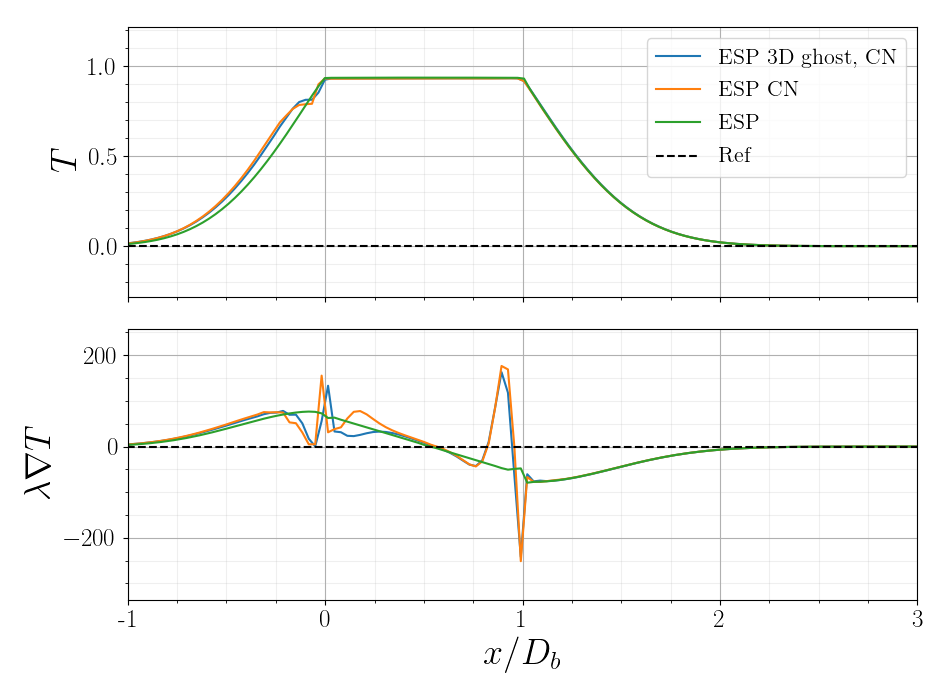

In [23]:
plotter = Plotter(
    "decale",
    flux_conv=False,
    lda_gradT=True,
    ispretty=True,
    zoom=(-1.0, 3.0),
    time=False,
)
plotter.plot(prob_gq, plot_Ti=True)
plotter.plot(prob_Ecn, plot_Ti=True)
plotter.plot(prob_E)
plotter.plot(prob_ref, ls="--", c="k", label="Ref")
# _ = plotter.ax.set_xlim(0.0065, 0.012)
# _ = plotter.ax.set_ylim(0.8,1.)
if save_fig:
    plotter.fig.savefig(savefig_path + "ESP_ESP3Dghost_CN.pdf")

### Observations

**Attention** : je vois un décalage d'une demi maille apparaitre pour chaque traversée du domaine (2.5 pour 5 traversées) entre la solution convectée et la solution non convectée.

Cette différence est présente sur les markers et la solution. Il y a surement un problème lors du passage des markers d'un côté à l'autre.

Tester une correction de la diffusion avec la diffusion calculée à l'interface à droite et à gauche. Dans le cas ESP 3D ghost. 

Avantage : cohérence lors du post-traitement entre le flux qu'on récupère et le flux qui est utilisé dans le code.

Vérifier qu'en rafinant la référence on n'observe pas une telle différence entre TOF et ESP sans correction diffusion.



## Test de la correction de la diffusion en utilisant la diffusion à l'interface

Ici on cherche à comprendre la différence entre la référence (TOF sans convection) et le bon résultat (perfectible probablement) obtenu avec la correction des flux diffusifs.

### Simulations

Les méthodes fonctionnent de la manière suivante :

- **ProblemDiscontinuComme3Davecq_I** :  
    On utilise les valeurs ghosts de la maille diphasique pour corriger les flux convectifs à proximité de
  l'interface (dans le stencil du quick).
    On corrige donc les flux en $i-1/2$, $i+1/2$ et $i+3/2$ en upwind.
    On corrige les flux diffusifs avec le flux à l'interface.


In [24]:
# prob_gudI = ProblemDiscontinuEcomme3Davecq_I(
#     get_T_creneau,
#     **init_params,
#     interp_type="Ti",
#     conv_interf="quick_upwind_ghost",
# )
prob_gqdI = ProblemDiscontinuEcomme3Davecq_I(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
    conv_interf="quick_ghost",
)


ESP 3D ghost, CN, corr. diff. qI
dt fourier
6.918433404737903e-06
Db / dx = 30
Ti


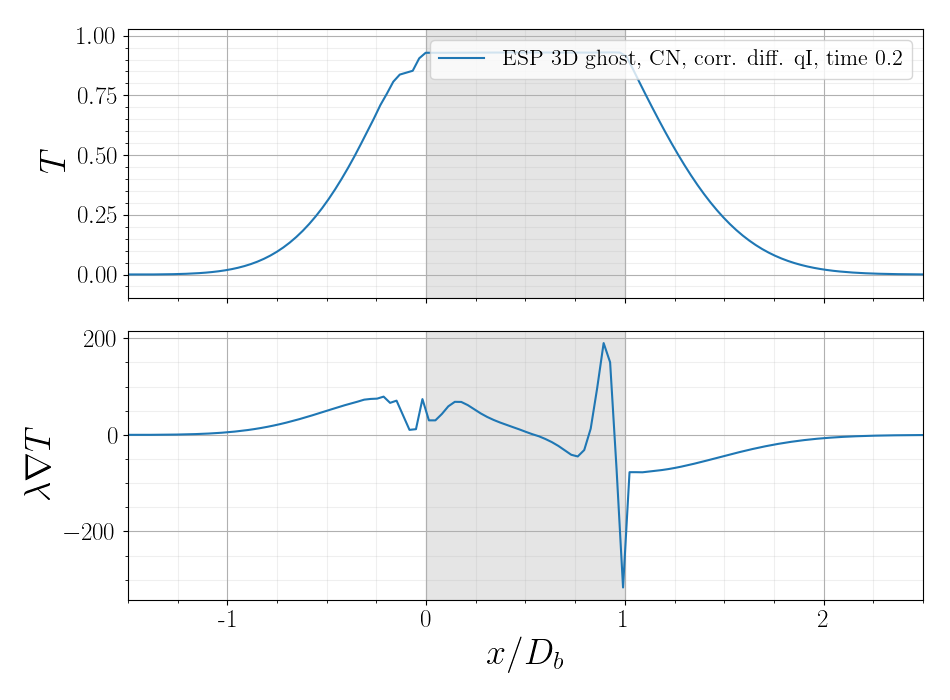

In [25]:
t_fin = 1.0

plot_tot = Plotter("decale", flux_conv=False, lda_gradT=True, zoom=(-1.5, 2.5))

time_args = {"t_fin": min(t_fin, t_fin_lim), "n": n_lim, "number_of_plots": 1}

# t_gudI, e_gudI = prob_gudI.timestep(
#     **time_args,
#     plotter=[plot_tot],
#     plot_Ti=True,
# )
t_gqdI, e_gqdI = prob_gqdI.timestep(
    **time_args,
    plotter=[plot_tot],
    plot_Ti=True,
)

'k'

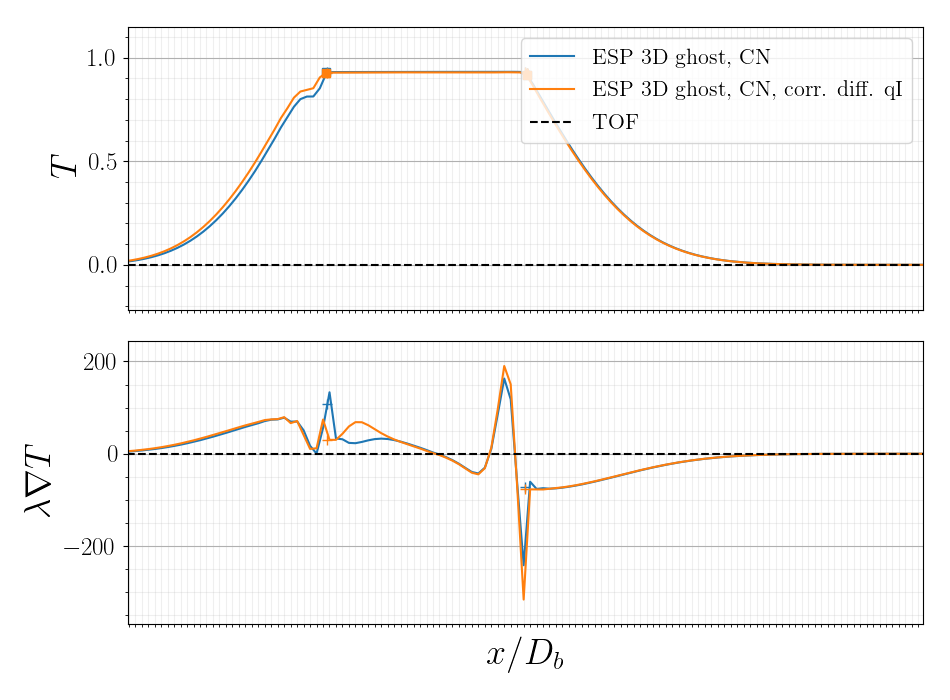

In [26]:
plotter = Plotter(
    "decale",
    flux_conv=False,
    lda_gradT=True,
    ispretty=False,
    time=False,
    zoom=(-1.0, 3.0),
)
plotter.plot(prob_gq, plot_Ti=True)
plotter.plot(prob_gqdI, plot_Ti=True)
plotter.plot(prob_ref, c="k", ls="--")
# plotter.plot(prob_ref)
# plotter.ax.set_xlim(0.0065, 0.012)
# plotter.ax.set_ylim(0.4,1.)

(-0.1, 1.0)

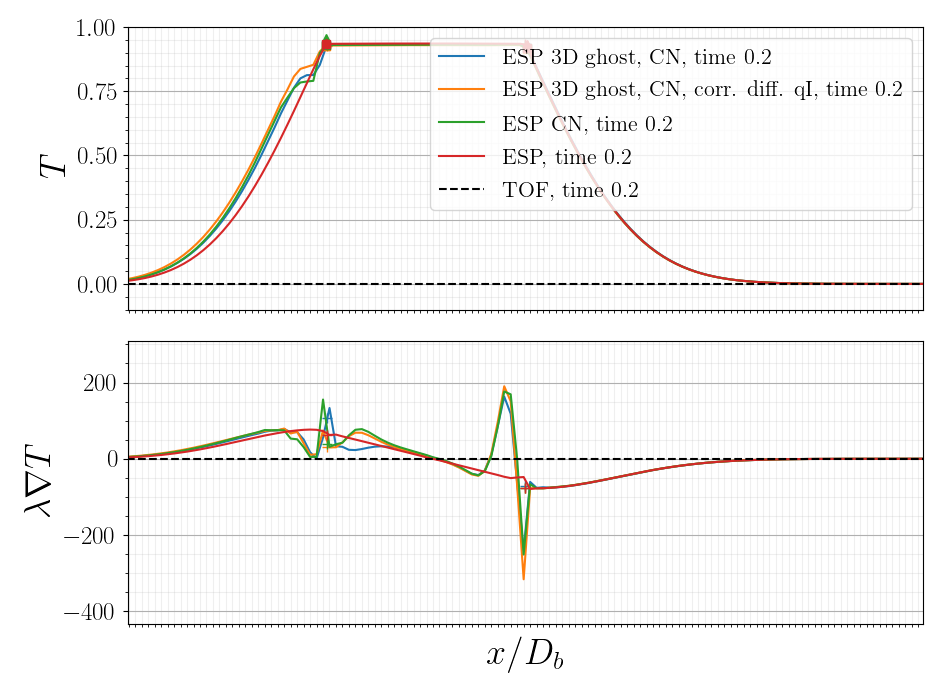

In [27]:
plotter = Plotter(
    "decale", flux_conv=False, lda_gradT=True, ispretty=False, zoom=(-1.0, 3.0)
)
plotter.plot(prob_gq, plot_Ti=True)
plotter.plot(prob_gqdI, plot_Ti=True)
plotter.plot(prob_Ecn, plot_Ti=True)
plotter.plot(prob_E, plot_Ti=True)
plotter.plot(prob_ref, c="k", ls="--")
# plotter.ax.set_xlim(0.0065, 0.015)
plotter.ax.set_ylim(-0.1, 1.0)

### Observations

Avantage : cohérence lors du post-traitement entre le flux qu'on récupère et le flux qui est utilisé dans le code.

Commentaire : la correction ne semble pas améliorer sensiblement la solution en température, voir elle la dégrade. En revanche elle permet d'avoir à l'interface un flux très proche du flux de la solution sans convection en amont. Il reste une erreur en aval dûe à l'interpolation upwind de la température.

## Test de la correction de la diffusion en utilisant la diffusion à l'interface et l'intégration exacte des surfaces

Ici on cherche à comprendre la différence entre la référence (TOF sans convection) et le bon résultat (perfectible probablement) obtenu avec la correction des flux diffusifs.

### Simulations

Les méthodes fonctionnent de la manière suivante :

- **ProblemDiscontinuComme3Davecq_I** :  
    On utilise les valeurs ghosts de la maille diphasique pour corriger les flux convectifs à proximité de
  l'interface (dans le stencil du quick).
    On corrige donc les flux en $i-1/2$, $i+1/2$ et $i+3/2$ en upwind.
    On corrige les flux diffusifs avec le flux à l'interface.


In [28]:
prob_gqdIS = ProblemDiscontinuEcomme3D_ghost_avecq_I_exactSf(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
    conv_interf="quick_ghost",
)


ESP 3D ghost, exact Sf, corr. diff. qI
dt fourier
6.918433404737903e-06
Db / dx = 30
Ti


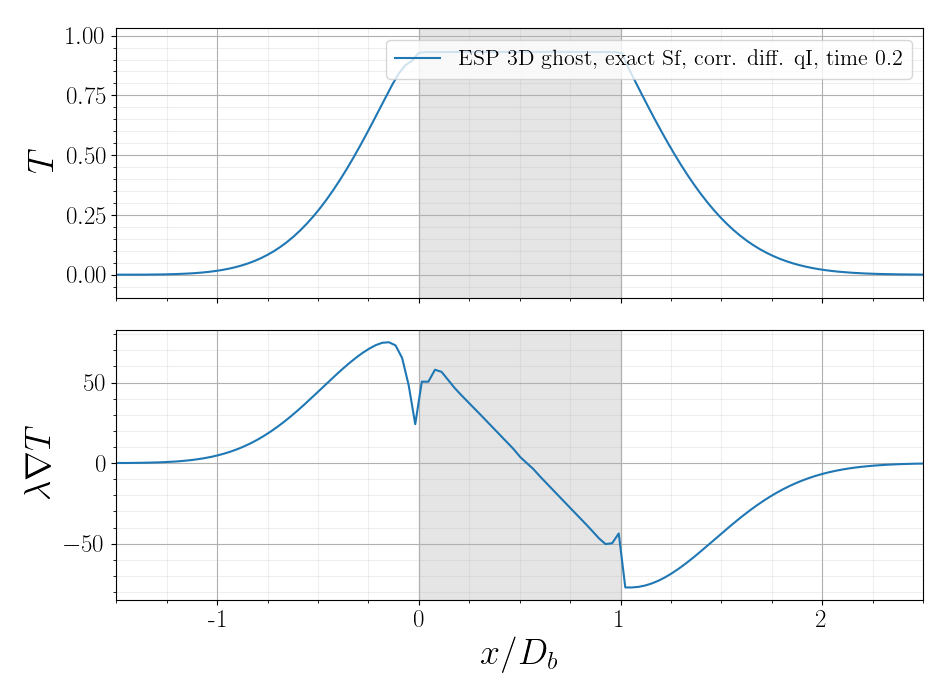

In [29]:
t_fin = 1.0

plot_tot = Plotter("decale", flux_conv=False, lda_gradT=True, zoom=(-1.5, 2.5))

time_args = {"t_fin": min(t_fin, t_fin_lim), "n": n_lim, "number_of_plots": 1}

t_gqdIS, e_gqdIS = prob_gqdIS.timestep(
    **time_args,
    plotter=[plot_tot],
    plot_Ti=True,
)

'k'

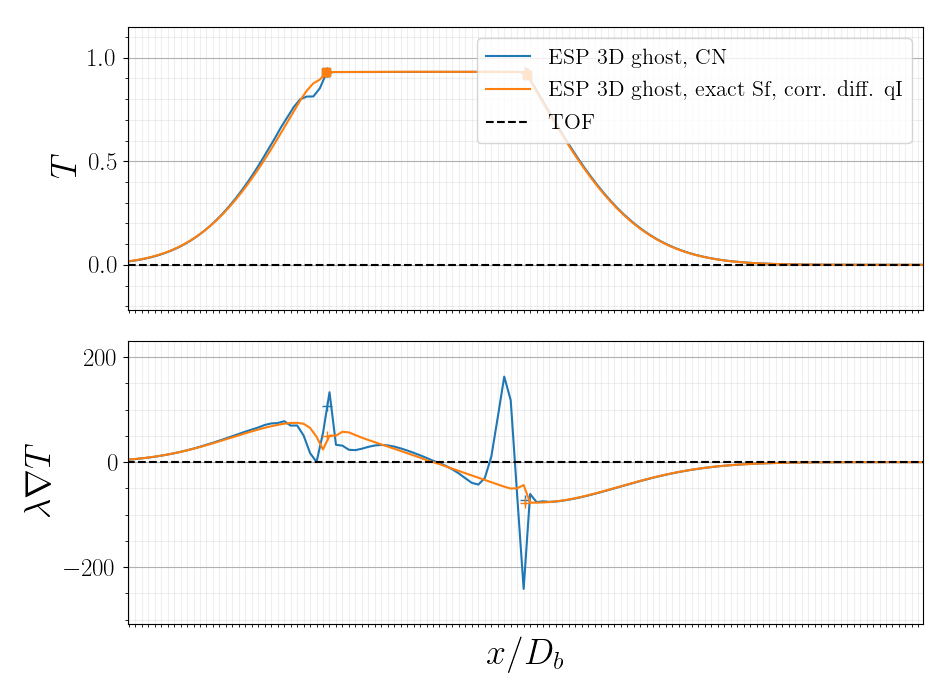

In [30]:
plotter = Plotter(
    "decale",
    flux_conv=False,
    lda_gradT=True,
    ispretty=False,
    time=False,
    zoom=(-1.0, 3.0),
)
plotter.plot(prob_gq, plot_Ti=True)
plotter.plot(prob_gqdIS, plot_Ti=True)
plotter.plot(prob_ref, c="k", ls="--")
# plotter.plot(prob_ref)
# plotter.ax.set_xlim(0.0065, 0.012)
# plotter.ax.set_ylim(0.4,1.)

(-0.1, 1.0)

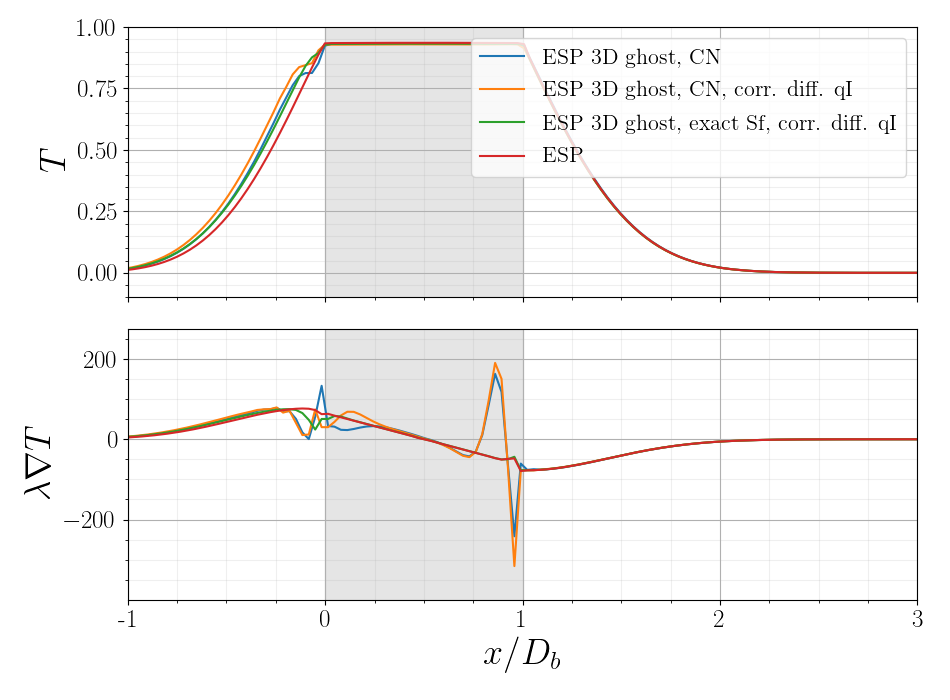

In [31]:
plotter = Plotter(
    "classic",
    flux_conv=False,
    lda_gradT=True,
    ispretty=True,
    zoom=(-1.0, 3.0),
    time=False,
)
plotter.plot(prob_gq, plot_Ti=True)
plotter.plot(prob_gqdI, plot_Ti=True)
plotter.plot(prob_gqdIS, plot_Ti=True)
# plotter.plot(prob_ref, c="k", ls="--")
plotter.plot(prob_E, plot_Ti=True)
# plotter.ax.set_xlim(0.0065, 0.015)
plotter.ax.set_ylim(-0.1, 1.0)

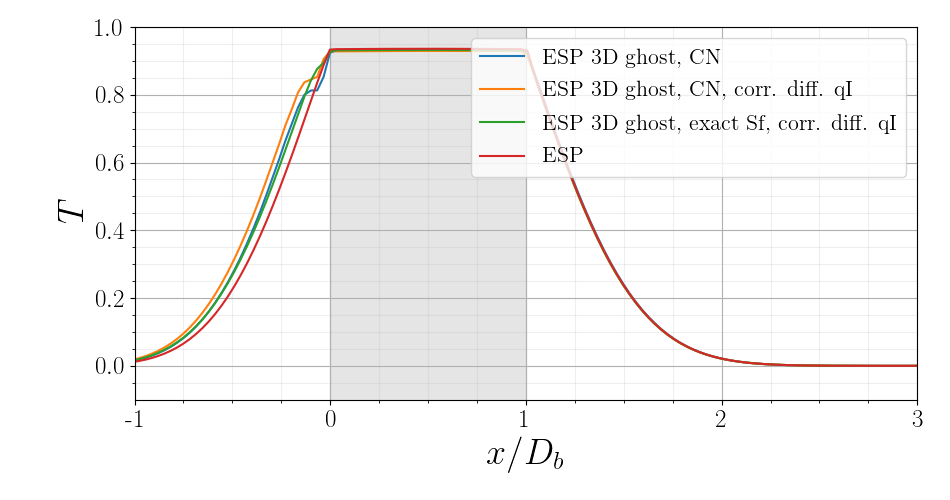

In [32]:
plotter = Plotter(
    "classic",
    flux_conv=False,
    lda_gradT=False,
    ispretty=True,
    zoom=(-1.0, 3.0),
    time=False,
)
plotter.plot(prob_gq, plot_Ti=True)
plotter.plot(prob_gqdI, plot_Ti=True)
plotter.plot(prob_gqdIS, plot_Ti=True)
# plotter.plot(prob_ref, c="k", ls="--")
plotter.plot(prob_E, plot_Ti=True)
# plotter.ax.set_xlim(0.0065, 0.015)
plotter.ax.set_ylim(-0.1, 1.0)
if save_fig:
    plotter.fig.savefig(savefig_path + "ESP3Dghost_resume.pdf")

### Observations

Avantage : cohérence lors du post-traitement entre le flux qu'on récupère et le flux qui est utilisé dans le code.

Commentaire : la correction ne semble pas améliorer sensiblement la solution en température, voir elle la dégrade. En revanche elle permet d'avoir à l'interface un flux très proche du flux de la solution sans convection en amont. Il reste une erreur en aval dûe à l'interpolation upwind de la température.